In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DRIVE_BASE = '/content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted'
REAL_FACES_DIR = os.path.join(DRIVE_BASE, 'faces', 'real')
FAKE_FACES_DIR = os.path.join(DRIVE_BASE, 'faces', 'fake')

real_files = sorted(glob.glob(os.path.join(REAL_FACES_DIR, '*.jpg')))
fake_files = sorted(glob.glob(os.path.join(FAKE_FACES_DIR, '*.jpg')))

print("Real faces:", len(real_files))
print("Fake faces:", len(fake_files))

N_REAL = 200
N_FAKE = 200
real_files = real_files[:N_REAL]
fake_files = fake_files[:N_FAKE]

Real faces: 27412
Fake faces: 58513


In [ ]:
def luminance_from_bgr(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb.astype(np.float32) / 255.0
    R, G, B = img_rgb[...,0], img_rgb[...,1], img_rgb[...,2]
    L = 0.2126 * R + 0.7152 * G + 0.0722 * B
    return L

def gradient_cov_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    L = luminance_from_bgr(img)

    Gx = cv2.Sobel(L, cv2.CV_32F, 1, 0, ksize=3)
    Gy = cv2.Sobel(L, cv2.CV_32F, 0, 1, ksize=3)

    gx_flat = Gx.reshape(-1)
    gy_flat = Gy.reshape(-1)
    M = np.stack([gx_flat, gy_flat], axis=1)

    mask = np.any(M != 0, axis=1)
    M = M[mask]
    if M.shape[0] < 10:
        return None

    N = M.shape[0]
    C = (M.T @ M) / float(N)
    vals, _ = np.linalg.eig(C)
    vals = np.sort(vals)[::-1]
    return vals[0], vals[1]


Fake PCA: 100%|██████████| 200/200 [01:08<00:00,  2.91it/s]


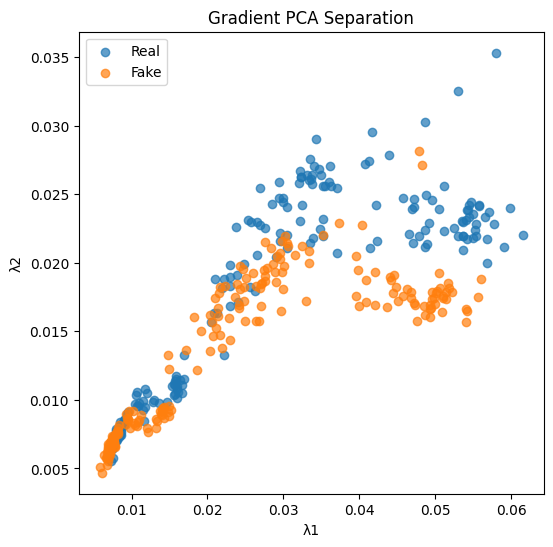

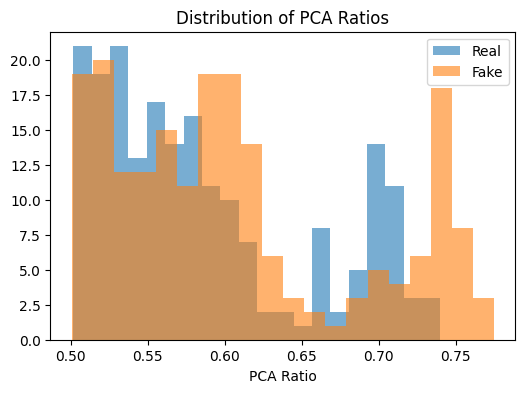

In [ ]:
real_vals = []
fake_vals = []

for f in tqdm(real_files, desc="Real PCA"):
    v = gradient_cov_features(f)
    if v is not None:
        real_vals.append(v)

for f in tqdm(fake_files, desc="Fake PCA"):
    v = gradient_cov_features(f)
    if v is not None:
        fake_vals.append(v)

real_vals = np.array(real_vals)
fake_vals = np.array(fake_vals)


plt.figure(figsize=(6,6))
plt.scatter(real_vals[:,0], real_vals[:,1], alpha=0.7, label="Real")
plt.scatter(fake_vals[:,0], fake_vals[:,1], alpha=0.7, label="Fake")
plt.xlabel("λ1")
plt.ylabel("λ2")
plt.legend()
plt.title("Gradient PCA Separation")
plt.show()


real_ratios = real_vals[:,0] / (real_vals[:,0] + real_vals[:,1])
fake_ratios = fake_vals[:,0] / (fake_vals[:,0] + fake_vals[:,1])

plt.figure(figsize=(6,4))
plt.hist(real_ratios, bins=20, alpha=0.6, label="Real")
plt.hist(fake_ratios, bins=20, alpha=0.6, label="Fake")
plt.xlabel("PCA Ratio")
plt.legend()
plt.title("Distribution of PCA Ratios")
plt.show()


In [ ]:
real_ratios = real_vals[:,0] / (real_vals[:,0] + real_vals[:,1])
fake_ratios = fake_vals[:,0] / (fake_vals[:,0] + fake_vals[:,1])

import numpy as np

all_ratios = np.concatenate([real_ratios, fake_ratios])
labels = np.concatenate([np.zeros_like(real_ratios), np.ones_like(fake_ratios)]) 


best_acc = 0
best_t = None

for t in np.linspace(all_ratios.min(), all_ratios.max(), 200):
    preds = (all_ratios > t).astype(int)  
    acc = (preds == labels).mean()
    if acc > best_acc:
        best_acc = acc
        best_t = t

print("Best threshold:", best_t)
print("Best accuracy using only PCA ratio:", best_acc)


Best threshold: 0.5861427
Best accuracy using only PCA ratio: 0.58
